In [1]:
import numpy as np
from scipy import stats
import random
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import os
os.environ['CUDA_DEVICE_ORDER'] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
import sys
import glob
import time

import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from IPython.display import Image
import imageio
import pandas as pd
# ----------------------------------------------
# ######## En local ############
path_dir = os.getcwd()
from config.utils import *
# ##############################
# ----------------------------------------------

print("TF version: ", tf.__version__)  # verifier d'avoir la version 2.3.0

%load_ext autoreload
%autoreload 2

TF version:  2.3.1


# Distribution normale univariée et sa fonction quantile
On se donne un échantillon de tirages i.i.d. $\{x_i \in \mathbb R \}_{i=1}^n$ de la loi normale standard $\mathcal N(0,1)$. Pour cela, il est possible soit de simuler ces données directement à partir la librairie [numpy](https://https://numpydoc.readthedocs.io/en/latest/format.html#docstring-standard), par exemple avec la fonction _numpy.random.randn_, soit de générer des tirages d'une loi uniforme sur $[0,1]$ et passer ensuite par l'inverse de la fonction de répartition $\Phi^{-1}(u) = \inf\{ x\in \mathbb R: u\leq \Phi(x)\}$, où $\Phi$ est la fonction de répartition (cdf en anglais) de la loi $\mathcal N(0,1)$. Parmi les méthodes de la librairie [scipy](https://docs.scipy.org/doc/scipy/reference/stats.html), la fonction **ppf** (*percent point function*) désigne la fonction inverse de la cdf.  

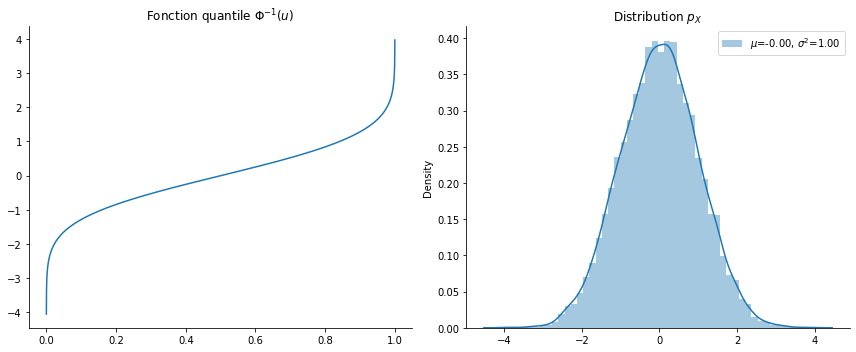

In [2]:
# information sur les données
np.random.seed(1234)
N_DATA = 10000
DATA_DIM = 1

# N_DATA tirages uniformes iid
uniform = np.random.uniform(size=(N_DATA, DATA_DIM))

# On transforme en N_DATA tirages gaussiens iid en appliquant l'inverse
# de la fct de répartition
dataset_train = stats.norm.ppf(uniform).astype(np.float32)

# La fonction viz_gaussian_train a été importée du fichier config.utils.py
# Elle permet d'obtenir l'affichage de la fonction stats.norm.ppf et de la distribution empirique
# des données, comme ci-dessous
viz_gaussian_train(uniform, dataset_train)

## Implémentation

**Pseudo-code**:

Le pseudo-code d'entrainement d'un GAN, cours 5.

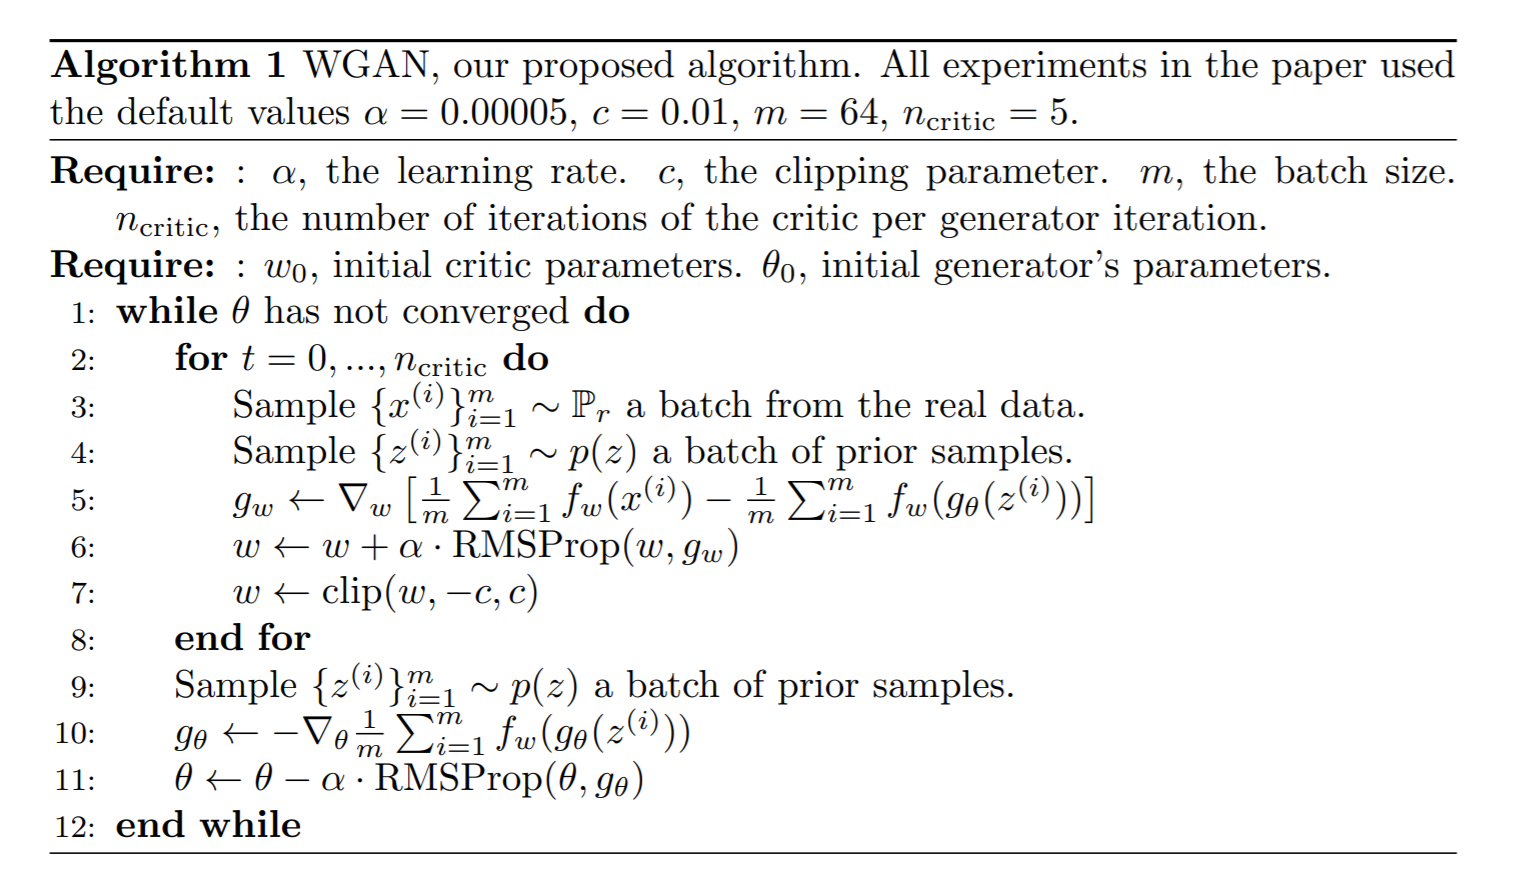

In [3]:
Image(filename=os.path.join(path_dir, "config", "screen", "PC_WGAN.png"), width=700, height=500)

### Generator

In [39]:
def build_generator(latent_dim, n_neurons, data_dim=DATA_DIM):
    """
    Construction du générateur
    
    Parameters
    ----------
    latent_dim: int
        Dimension de la variable latente
    n_neurons: int
        Nombre de neurones dans la couche cachée
    data_dim: int
        Dimension de l'espace des données 

    Returns
    -------
    tf.Model
        Générateur du GAN
    """    
    model = tf.keras.Sequential(name="Generator")
    model.add(layers.Dense(n_neurons, input_shape=(latent_dim,), bias_initializer="glorot_normal"))
    
    # On utilise ici une fonction d'activation LeakyReLU : sigma(x) = ...
    # Vous pourrez tester d'autres exemples de fonction d'activation (e.g. ReLU, ou LeakyReLU avec 
    # d'autres valeurs de alpha) pour comparaison
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(data_dim, bias_initializer="glorot_normal"))
    return model

G_test = build_generator(latent_dim=1, n_neurons=10)
G_test.summary()  # essayer la fonction "plot_model(G_test, show_shapes=True)"

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 10)                20        
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 10)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 11        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


### Discriminator

In [38]:
def build_discriminator(n_neurons, data_dim=DATA_DIM):
    """
    Construction du discriminateur
    
    Parameters
    ----------
    n_neurons: int
        Nombre de neurones dans les couches cachées
    data_dim: int
        Dimension de l'espace des données

    Returns
    -------
    tf.Model
        Discriminateur du GAN
    """
    model = tf.keras.Sequential(name="Discriminator")
    model.add(layers.Dense(n_neurons, input_shape=(DATA_DIM,), bias_initializer="glorot_normal", 
                           kernel_initializer="glorot_normal"))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    ####################################################
    # A COMPLETER:
    # 1/ ajouter une deuxième couche cachée avec la meme 
    # configuration que la précédente (nombre de neurones, 
    # fct d'activation)
    
    #2/ ajouter la couche de sortie (sans fonction sigmoïde)
    model.add(layers.Dense(n_neurons, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(units = 1, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
    ####################################################
    return model

D_test = build_discriminator(n_neurons=10)
D_test.summary()  # essayez la fonction "plot_model(D_test, show_shapes=True)"

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 10)                20        
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 10)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 10)                110       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 10)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [32]:
def discriminator_loss_wgan(real_output, fake_output): 
    """
    Fonction de coût du discriminateur

    Parameters
    ----------
    real_output: arr
        Sorties du discriminateur D(x)
    fake_output: arr
        Sorties du générateur D(G(z))

    Returns
    -------
    float
        Moyenne des fonctions de coûts dans le batch
    """
    return -tf.reduce_mean(real_output) + tf.reduce_mean(fake_output)
  
def generator_loss_wgan(fake_output):
    """
    Fonction de coût du générateur

    Parameters
    ----------
    fake_output: arr
        Sorties du générateur D(G(z))

    Returns
    -------
    float
        Moyenne des fonctions de coûts dans le batch
    """
    return -tf.reduce_mean(fake_output)

### Definir la fonction d'entraînement

<font color ="red"> **Relancez toujours cette cellule avant de lancer la boucle d'entraînement !**

In [45]:
tf.random.set_seed(1234)
np.random.seed(1234)
counter_seed = 0

# Choix des paramètres d'entrainement:
BATCH_SIZE = 50
LATENT_DIM = 1
EPOCHS =  30
NEURONS_G = 100
NEURONS_D = 100
k = 10

# Construction du GAN
generator_wgan = build_generator(LATENT_DIM, NEURONS_G)
discriminator_wgan = build_discriminator(NEURONS_D)
generator_optimizer_wgan = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
discriminator_optimizer_wgan = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

# pour l'affichage
list_loss_G_train_wgan=[]
list_loss_D_train_wgan=[]

# ===========================================================================
# ===========================================================================
@tf.function
def train_step_wgan(data_batch, noise_dim, c = 0.01, n_critic = 5):
    """
    Calcul du gradient et mise à jour des paramètres à chaque itération

    Parameters
    ----------
    data_batch: arr
        Batch de données (x_1, ..., x_m)
    noise_dim: int
        Dimension de la variable latente
    """
    
    tf.random.set_seed(counter_seed)  # actualisation de la seed pour chaque train_step 
    batch_size = data_batch.shape[0]
    
    for _ in range(n_critic):
        # Entrainement du Discriminateur
        noise = tf.random.uniform([batch_size, noise_dim],minval=-1.,maxval =1.)  # z = (z_1, .., z_m)
        with tf.GradientTape() as disc_tape:
            generated_data = generator_wgan(noise)  # G(z)  
            real_output = discriminator_wgan(data_batch)  # D(x)
            fake_output = discriminator_wgan(generated_data)  # D(G(z))

            disc_loss = discriminator_loss_wgan(real_output, fake_output)  # calcul de la loss du discriminateur

        # calcul du gradient
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_wgan.trainable_variables)

        # mise à jour des paramètres
        discriminator_optimizer_wgan.apply_gradients(zip(gradients_of_discriminator, discriminator_wgan.trainable_variables))

            # clip the weight of D
        for p in discriminator_wgan.trainable_variables:
            p.assign(tf.clip_by_value(p, -c, c))
        
        
    # Entrainement du Générateur
    noise = tf.random.uniform([batch_size, noise_dim],minval=-1.,maxval=1.) # z = (z_1, .., z_m)
    with tf.GradientTape() as gen_tape:
        generated_data = generator_wgan(noise)  # G(z) 
        fake_output = discriminator_wgan(generated_data)  # D(G(z))
        
        gen_loss = generator_loss_wgan(fake_output)  # calcul de la loss du générateur
    
    # calcul du gradient
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_wgan.trainable_variables)
    
    # mise à jour des paramètres
    generator_optimizer_wgan.apply_gradients(zip(gradients_of_generator, generator_wgan.trainable_variables))
    return

def evaluate_wgan(data, noise_test):
    """
    Evaluation de l'erreur du générateur et du discriminateur (à utiliser pour l'affichage
    à la fin de l'entrainement)
    
    Parameters
    ----------
    data: arr
        Données de taille n, x=(x_1,..., x_n)
    noise_test: arr
        Bruit de taille n, z=(z_1,..., z_n)
        
    Returns
    -------
    loss_G: float
        valeur de la fonction de coût du générateur
    loss_D: float
        valeur de la fonction de coût du discriminateur
    """
    
    generated_data = generator_wgan(noise_test) #G(z)
    real_output = discriminator_wgan(data)# D(X)
    fake_output = discriminator_wgan(generated_data) # D(G(z))
    
    loss_D = discriminator_loss_wgan(real_output, fake_output)
    loss_G = generator_loss_wgan(fake_output)

    return loss_G.numpy(), loss_D.numpy()

**Visualisation avant entraînement**

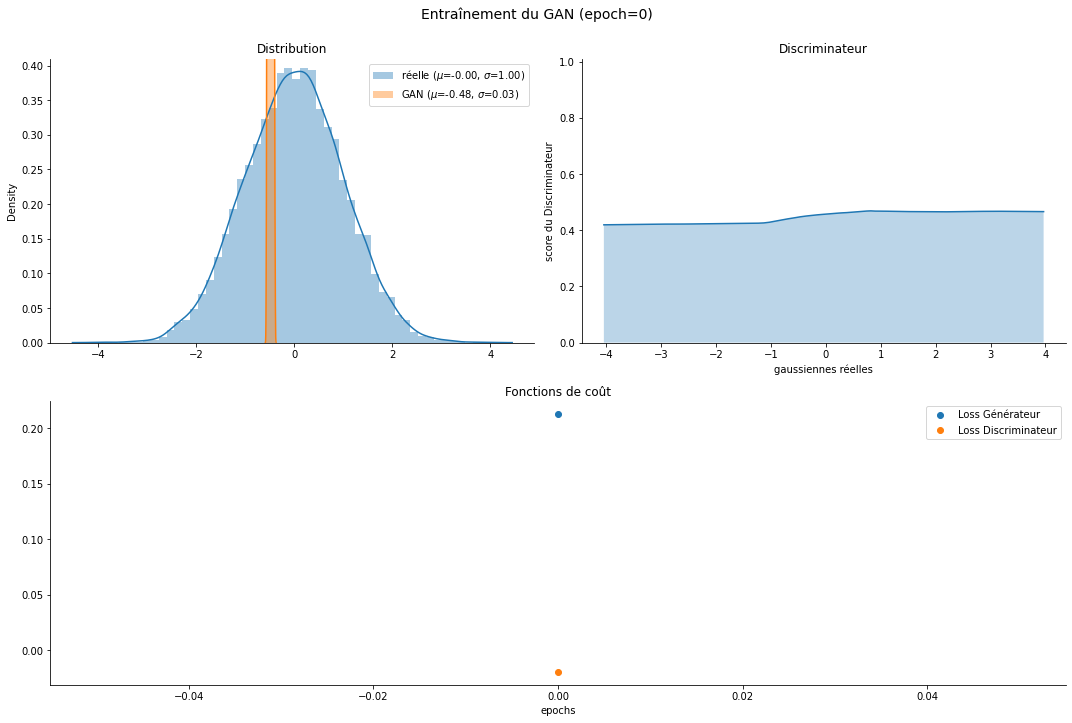

In [41]:
np.random.seed(1234)
noise_test = np.random.uniform(size=(N_DATA, LATENT_DIM))

# évaluation sur toutes les données avec un bruit test fixe
loss_G, loss_D = evaluate_wgan(dataset_train, noise_test)  
list_loss_G_train_wgan.append(loss_G)
list_loss_D_train_wgan.append(loss_D)

# Une autre fonction importée du fichier utils.py
viz_gaussian_gan(noise_test, dataset_train, generator_wgan, discriminator_wgan, list_loss_G_train_wgan, list_loss_D_train_wgan, epoch=0)

plt.savefig(os.path.join(path_dir, "imgs", "gaussian", "image_gaussianWGANm_N{}-Ldim{}-bs{}_at_epoch_{}.png".format(
    N_DATA, LATENT_DIM, BATCH_SIZE, 0)))

**Entraînement**

In [42]:
list_loss_G_train_wgan

[0.2127135]

In [43]:
len(list_loss_D_train_wgan)

1

Fin de l'entraînement.


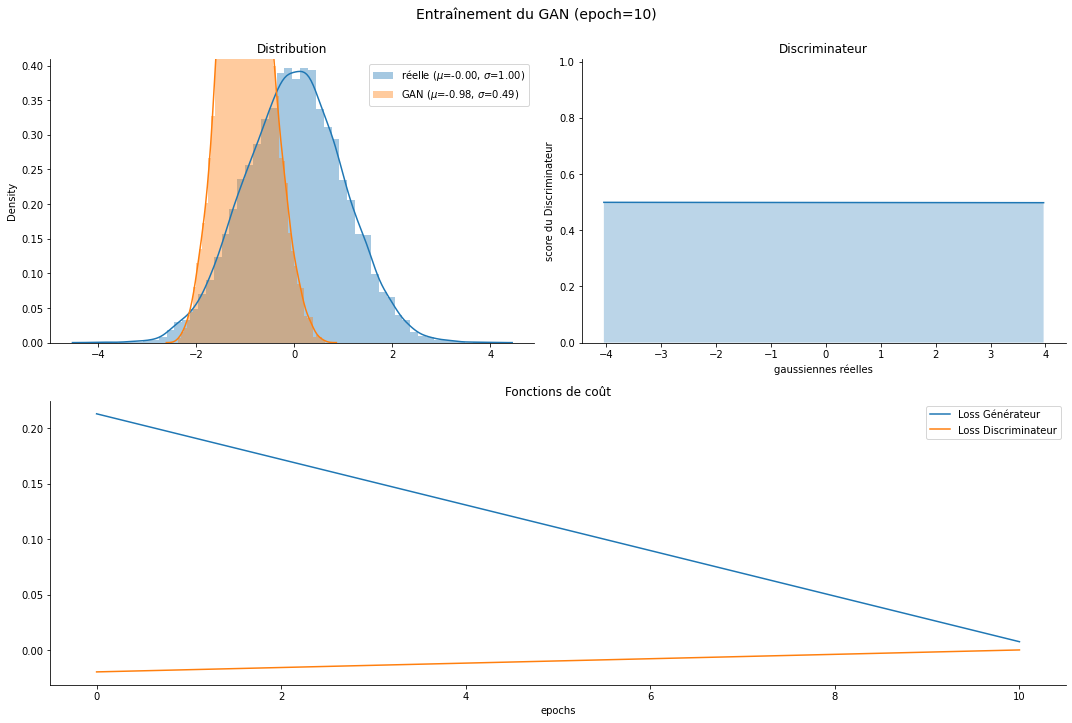

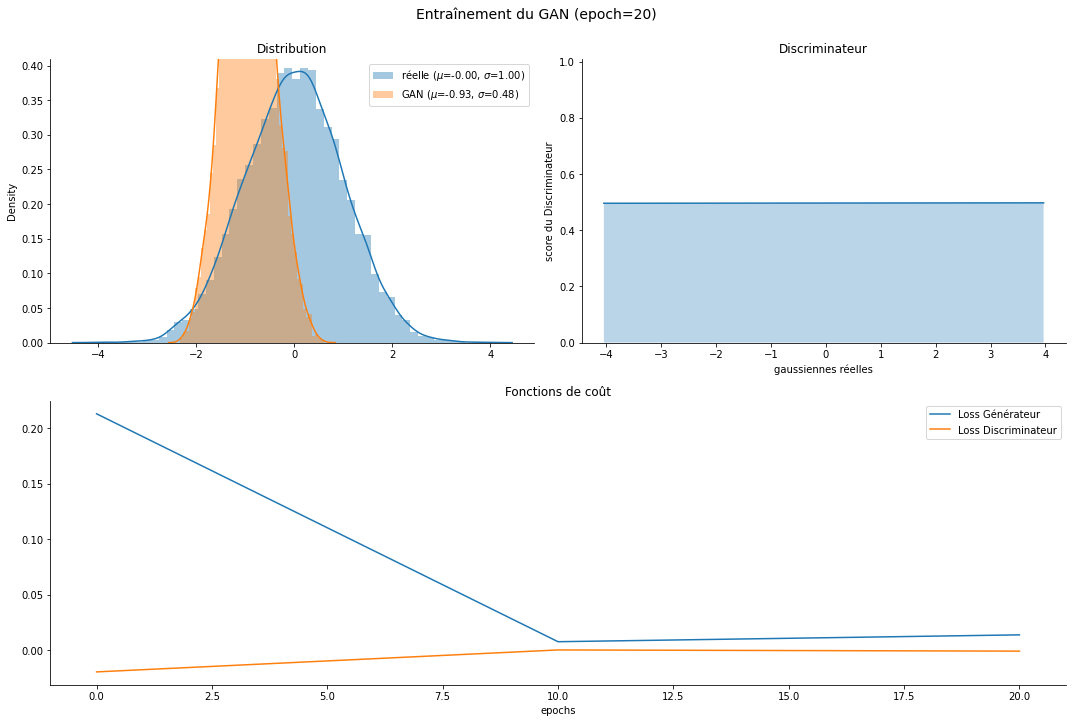

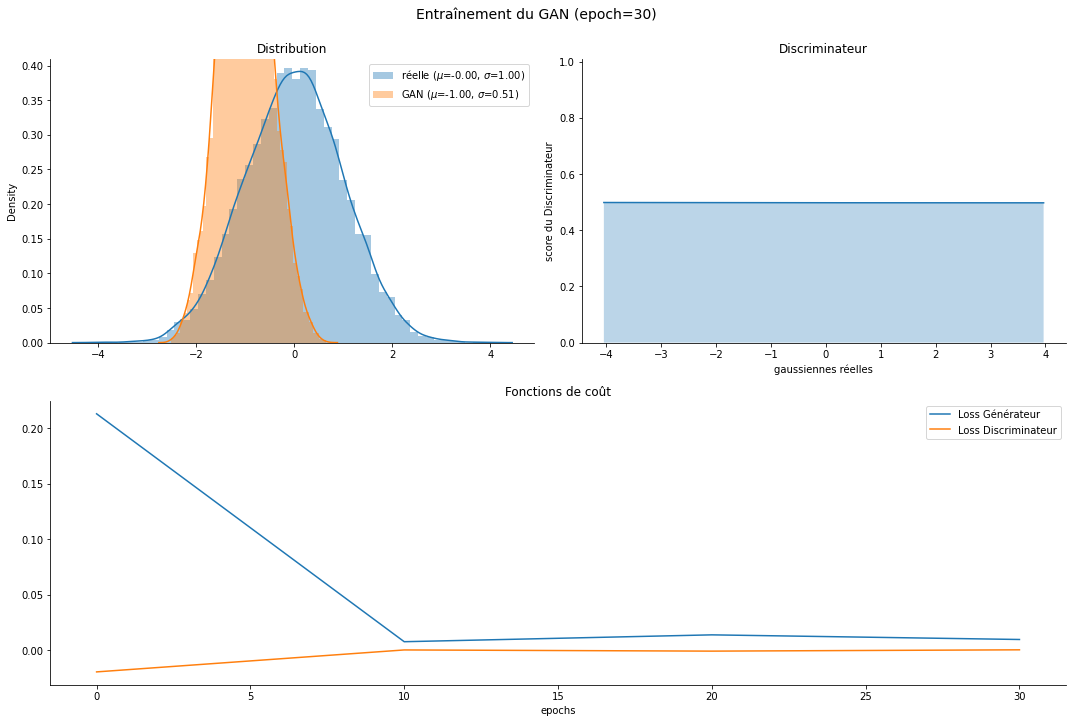

In [44]:
# Boucle d'entraînement:
print("Début de l'entraînement ...")

# division des données en batch de taille BATCH_SIZE
data_batches = tf.data.Dataset.from_tensor_slices(dataset_train).batch(BATCH_SIZE)
# np_data_batches = np.stack(list(data_batches))

for epoch in range(1, EPOCHS+1):
    # print("epoch = {}".format(epoch))
    start_time= time.time()
    counter_seed+=1
    
#     # mélange des données avec aléa fixé
#     data_shuffle = shuffle(dataset_train, random_state=counter_seed)
#     data_batches = tf.data.Dataset.from_tensor_slices(data_shuffle).batch(BATCH_SIZE)
    
    for data_batch in data_batches:
        counter_seed += 1
        train_step_wgan(data_batch, LATENT_DIM)
    
    if (epoch) % 10 == 0:    
        # évaluation à epoch modulo 10 sur toutes les données avec un bruit test fixe
        loss_G, loss_D = evaluate_wgan(dataset_train, noise_test)  
        list_loss_G_train_wgan.append(loss_G)
        list_loss_D_train_wgan.append(loss_D)
        
        #time_epoch = time.time() - start_time
        display.clear_output(wait=True)
        # print("Epoch {} ({:.2f} sec): Loss Generateur={:.3f}, Loss Discriminateur={:.3f}".format(\
        #     epoch, time_epoch, loss_G, loss_D))

        viz_gaussian_gan(noise_test, dataset_train, generator_wgan, discriminator_wgan, 
                         list_loss_G_train_wgan, list_loss_D_train_wgan, epoch)

        # sauvegarde image
        plt.savefig(os.path.join(path_dir, "imgs", "gaussian", "image_gaussian_N{}-Ldim{}-bs{}_at_epoch_{}_on_{}.png".format(N_DATA, LATENT_DIM, BATCH_SIZE, epoch, EPOCHS)))

    if (epoch) % (EPOCHS/10) == 0:
        # sauvegarde les modèles 10 fois durant l'entraînement
        generator_wgan.save(os.path.join(path_dir, "models", "gaussian", "generator-N{}-Ldim{}-epoch{}-bs{}.h5".format(
            N_DATA, LATENT_DIM, EPOCHS, BATCH_SIZE)))
            
        discriminator_wgan.save(os.path.join(path_dir,"models", "gaussian", "discriminator-N{}-Ldim{}-epoch{}-bs{}.h5".format(
            N_DATA, LATENT_DIM, EPOCHS, BATCH_SIZE)))
        
save_GIF(path_dir, N_DATA, LATENT_DIM, BATCH_SIZE, EPOCHS)   
print("Fin de l'entraînement.")